In [14]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import pickle
import math 

In [2]:
def drop_one_airport(adj,name):
    index_row = adj.columns.get_loc(name)
    adj[name]=0
    adj.loc[index_row]=0
    return adj.to_numpy()
    
adj = pd.read_csv('./init_flight_capacity.csv')
# AAL is the airport to cutted all connection
adj_new = drop_one_airport(adj,'HKG')
# adj_new.shape

In [3]:
# adj_matrix contain the flight info with passenger num
# when cutted, rmb to change this file
# adj_matrix = np.load("init_flight_capacity.npy")
adj_matrix = adj_new

with open("terminal_name.txt") as f:
    airport_id = f.readlines()
airport_id = [i.replace("\n", "") for i in airport_id]

with open('city_id2airports.pickle', 'rb') as handle:
    cityid2airportid = pickle.load(handle)

with open('cityid2population.pickle', 'rb') as handle:
    cityid2population = pickle.load(handle)
    
with open('cityid_passengers_from_to.pickle', 'rb') as handle:
    cityid_outprob = pickle.load(handle)
flights_data = pd.read_csv("flights.csv")
# flights_data
# adj_matrix.shape

In [4]:
airport_id[154]

'HKG'

In [5]:
# fix nan
# cityid2population_e[3442] = 8604203.0
# cityid2population_e[86] = 7398000.0
# cityid2population_e[29867] = 593754.0


In [6]:
# cityid2airportid = {2451:["AAR", "AAL"],719:["ABI"] }       
# cityid2population = {2451: 237551.0, 719: 693494.0}
# cityid_outprob = {2451: {"AAR_PER": 0.4, "AAR_ABI": 0.3, "AAL_ABI":0.3}, 719: {"ABI_AAR": 1.0}}

beta_city = [0.779 for i in range(len(cityid2airportid))]
gamma_city = [0.03 for i in range(len(cityid2airportid))]
beta_flight = np.load("beta.npy") # infection rate
gamma_flight = np.copy(beta_flight)
gamma_flight[gamma_flight != 0] = 0.03 # recovery rate


In [12]:
def ppl_same_city_in_plane(airports, probabilities, infection_num_out):
    fetch = random.choices(airports, weights=probabilities, k=int(infection_num_out))

    infection_num_out_list=[]
    for item in airports:
        infection_num_out_list.append(fetch.count(item))
        
    return infection_num_out_list

def update_infection(arrive_infection_matrix):
    update_dictionary = dict(zip(airport_id, np.sum(arrive_infection_matrix, axis=0)))
    return update_dictionary

def get_infection_input(infection_dictionary):   
    city_infection_input = dict.fromkeys(cityid2airportid.keys(), 0)
    for k, v in cityid2airportid.items():
        infection_num = []
        for i in v:
            infection_num.append(infection_dictionary[i])
        city_infection_input[k] = sum(infection_num)
    return city_infection_input

def city_infection(city_infection_input, city_recovery):
    city_infection_num = np.array(list(city_infection_input.values()))
    city_population = np.array(list(cityid2population.values()))
    y_c = [(city_population - city_infection_num)/city_population, city_infection_num/city_population, city_recovery]
    
    s, i ,r = SIR(y_c, beta_city, gamma_city)
    
    after_infection = np.ceil(i*city_population)
    return r, after_infection


def flight_infection(flight_adj, flight_infection_num):

    y_f = [np.nan_to_num((flight_adj-flight_infection_num)/flight_adj,nan = 1),\
           np.nan_to_num(flight_infection_num/flight_adj, nan = 0),\
           np.zeros(len(flight_adj))]
    
    
    s, i ,r = SIR(y_f, beta_flight, gamma_flight)
    
    arrive_infection = np.nan_to_num(np.ceil(i*flight_adj), nan = 0)
    
    infection_ppl_flight = update_infection(arrive_infection)
    
    return infection_ppl_flight

def get_on_plane(flight_infection_matrix, infection_ppl_in_airport):
    for (k, v), num_of_people in zip(cityid_outprob.items(), infection_ppl_in_airport):
        people_on_plane = ppl_same_city_in_plane(list(v.keys()), list(v.values()), num_of_people)
        flight_infection_matrix = update_flight_infection(flight_infection_matrix, list(v.keys()), people_on_plane)
    return flight_infection_matrix
    
def fly_infection_ppl(city_infection_ppl):
    return np.nan_to_num(np.ceil(city_infection_ppl/1),nan = 1)
    

def SIR(y, beta, gamma):
    S, I, R = y 
    d0 = S - beta*S*I # derivative of S(t)
    d1 = I + beta*S*I - gamma*I # derivative of I(t)
    d2 = R+ gamma*I # derivative of R(t)
    
    return [d0, d1, d2]

def update_flight_infection(flight_infection, flight_com, ppl_num_list):
    flight_com = [i.split("_") for i in flight_com]
    for (flight_from, flight_to), infection_num in zip(flight_com, ppl_num_list):
        flight_from_id = airport_id.index(flight_from)
        flight_to_id = airport_id.index(flight_to)
        flight_infection[flight_from_id][flight_to_id] += infection_num
    return flight_infection
    

def loop_infection(n_iter, flight_adj):
    flight_infection_num = np.zeros((len(flight_adj), len(flight_adj)))
    #   flight_infection_num[fromcity][Tocity] = num_of_start_infection
    #   fromcity means the order from terminal_name file, AAL -> 0
    flight_infection_num[0][1] = 1
    
    city_recovery = [0.03 for i in range(len(cityid2airportid))]
    infection_ppl_list = [1]
    
    for _ in tqdm(range(n_iter)):
        infection_ppl_flight = flight_infection(flight_adj, flight_infection_num)
        
        infection_ppl_city = get_infection_input(infection_ppl_flight)
        city_recovery, infection_ppl = city_infection(infection_ppl_city, city_recovery)
        
        flight_infection_num = get_on_plane(np.zeros((len(flight_adj), len(flight_adj))), fly_infection_ppl(infection_ppl))
        infection_ppl_list.append(np.sum(infection_ppl))
    
    return flight_infection_num, infection_ppl_list
        

#  10-> loop iter, adj_matrix could be init or cutted matrix load from beginning
matrix, infection_list = loop_infection(100, adj_matrix)
print(infection_list)
matrix

  0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in multiply
/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in multiply
/opt/anaconda3/envs/ns/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


[1, 4.0, 13.0, 46.0, 153.0, 489.0, 1666.0, 5362.0, 17003.0, 51391.0, 149587.0, 396027.0, 832933.0, 1002514.0, 939061.0, 977811.0, 949251.0, 972116.0, 952467.0, 965696.0, 956008.0, 962964.0, 957118.0, 961511.0, 959744.0, 961258.0, 957486.0, 958978.0, 963795.0, 960095.0, 959729.0, 961872.0, 956805.0, 962972.0, 961547.0, 962043.0, 959879.0, 962697.0, 959631.0, 962432.0, 958262.0, 960914.0, 960012.0, 958408.0, 963027.0, 958202.0, 958330.0, 964221.0, 958335.0, 959863.0, 961833.0, 962881.0, 955993.0, 964733.0, 959863.0, 963805.0, 960588.0, 958649.0, 961007.0, 954598.0, 965122.0, 957002.0, 962524.0, 959395.0, 960469.0, 958353.0, 961110.0, 958758.0, 959163.0, 957056.0, 960224.0, 956746.0, 964311.0, 957560.0, 961649.0, 957964.0, 962702.0, 957429.0, 963623.0, 958337.0, 957104.0, 960552.0, 958860.0, 962865.0, 960326.0, 959141.0, 960218.0, 961445.0, 959552.0, 959438.0, 959209.0, 963409.0, 957694.0, 961830.0, 960642.0, 960294.0, 961449.0, 957133.0, 959971.0, 959422.0, 961071.0]


array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

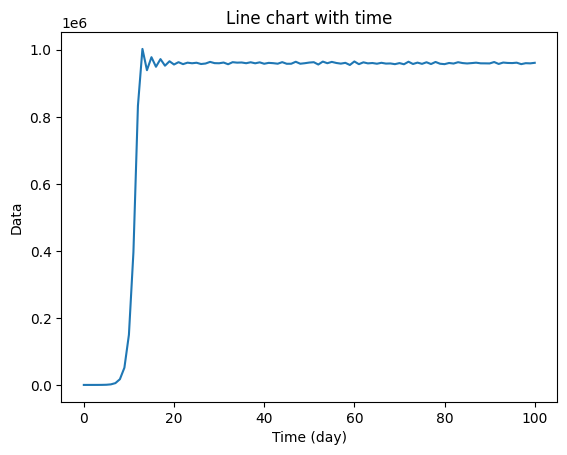

In [13]:
import matplotlib.pyplot as plt

# Time data (in months)
time = [i for i in range(len(infection_list))]

# Data to be plotted
data = infection_list

# Create the plot
plt.plot(time, data)

# Add a title and labels to the plot
plt.title('Line chart with time')
plt.xlabel('Time (day)')
plt.ylabel('Data')

# Show the plot
plt.show()


In [9]:
adj_matrix

array([[   0.,    9.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      